# Lab 3 — dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import functions
from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [3]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

Loading data

In [4]:
scores_data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
movies_data = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
ratings_data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

## Exercise 3.1

In [5]:
scores_data.take(2)

[{'movieId': 1, 'relevance': 0.025000000000000022, 'tagId': 1},
 {'movieId': 1, 'relevance': 0.025000000000000022, 'tagId': 2}]

In [6]:
#scores=scores_data.collect() taking toolong
#create a dataframe to deal with the scores that are too big otherwise
from pyspark.sql import SQLContext, Row
scores_DF = scores_data.map(lambda l: Row(**dict(l))).toDF()

In [7]:
#group the scores by movieId
scores_grouped=scores_DF.groupBy('movieId').agg(functions.collect_list('relevance'),functions.collect_list('tagId'))

In [8]:
scores_grouped.show(3)

+-------+-----------------------+--------------------+
|movieId|collect_list(relevance)| collect_list(tagId)|
+-------+-----------------------+--------------------+
|     31|   [0.04099999999999...|[1, 2, 3, 4, 5, 6...|
|    231|   [0.04425000000000...|[1, 2, 3, 4, 5, 6...|
|    431|   [0.02700000000000...|[1, 2, 3, 4, 5, 6...|
+-------+-----------------------+--------------------+
only showing top 3 rows



In [9]:
#convert to lists
#scores- list of Row with movieId, relevance list and tag list
scores=scores_grouped.collect()
#movies- list of dict with genres list, movieId and title
movies=movies_data.collect()

* Construct an M×N data matrix, where M is the number of tags and N the number of movies. Do not include movies which do not have any tag.

In [10]:
movie_matrix = np.zeros((len(tag2name),len(scores))) # MxN matrix using len(scores) to exclude movies without tags
movieId_matrix =[]

for index,row in enumerate(scores):
    movieId = row[0]
    relevances=row[1]
    tags=row[2]
    
    movieId_matrix.append(movieId)
    
    for relevance, tag in zip(relevances,tags):
        movie_matrix[tag-1,index]=relevance #tags start with 1 
    

In [11]:
#this is our data matrix, calling it M
M=movie_matrix
movie_matrix

array([[ 0.041  ,  0.04425,  0.027  , ...,  0.01825,  0.0385 ,  0.068  ],
       [ 0.05125,  0.04825,  0.02725, ...,  0.024  ,  0.03875,  0.08525],
       [ 0.0205 ,  0.01925,  0.01975, ...,  0.076  ,  0.024  ,  0.0215 ],
       ..., 
       [ 0.01225,  0.0115 ,  0.01125, ...,  0.01125,  0.0175 ,  0.009  ],
       [ 0.08025,  0.07825,  0.07225, ...,  0.076  ,  0.16825,  0.96475],
       [ 0.01675,  0.01425,  0.01825, ...,  0.01825,  0.0275 ,  0.93775]])

#### Plotting

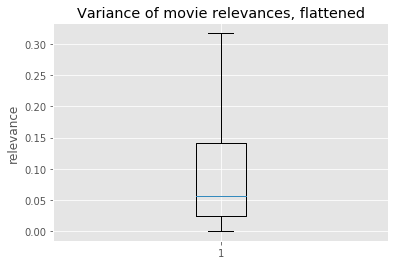

In [12]:
plt.boxplot(M.flatten(),0,'')
plt.title("Variance of movie relevances, flattened")
plt.ylabel("relevance")
plt.show()

We can see that the mean value of the relevances is close to 0.05 which is quite low. The variance shows that even if there are a few higher relevances most of the relevances are close and a little below 0.05. 
The relevance denotes the relevance of the tagg? so the tag relevances seem to be very low

*  Plot the variance of each dimension (represented by tags) across all movies.

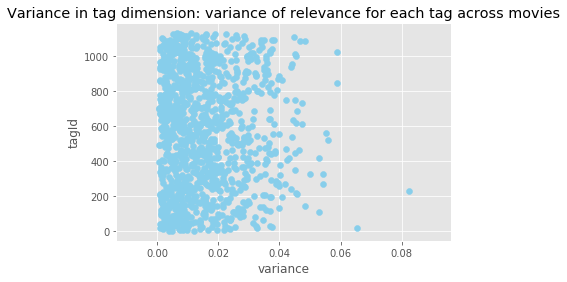

In [13]:
#variances along axis 0 - tag dimension
M1_var=np.var(M,axis=1)
plt.scatter(M1_var,range(1,len(M1_var)+1),facecolor='skyblue')
plt.title("Variance in tag dimension: variance of relevance for each tag across movies")
plt.ylabel("tagId")
plt.xlabel("variance")
plt.show()

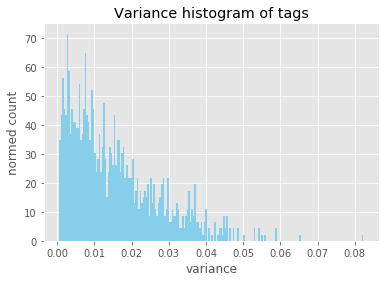

In [14]:
#import matplotlib
plt.hist(M1_var, bins=200,normed=1,facecolor='skyblue')
plt.title("Variance histogram of tags")
plt.ylabel("normed count")
#_,ax1=plt.subplots()
#ax1.set_xscale('log')
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel("variance")
plt.show()

The variances are rather small, so it seems that most of the tags have approximately the same relevance in each movie.


As the variances are low, the means can be informative. Below one can see that there are some tags with quite high relevance across all movies.

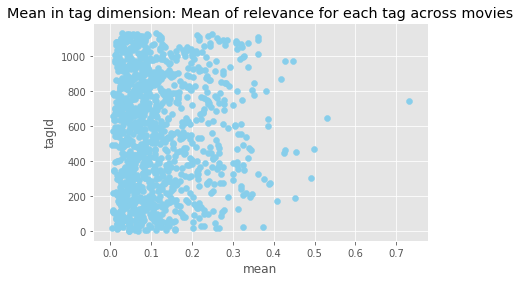

In [15]:
M1_mean=np.mean(M,axis=1)
plt.scatter(M1_mean,range(1,len(M1_mean)+1),facecolor='skyblue')
plt.title("Mean in tag dimension: Mean of relevance for each tag across movies")
plt.ylabel("tagId")
plt.xlabel("mean")
plt.show()

In [16]:
var_indx=np.argsort(M1_var) #sort indices
var_high=[tag2name[indx+1] for indx in var_indx[-7:] ] 
var_low=[tag2name[indx+1] for indx in var_indx[:7] ] 
print ("Tags with highest relevance variance: ", var_high)
print ("Tags with lowest relevance variance: ", var_low) 

Tags with highest relevance variance:  ['criterion', 'intimate', 'horror', 'relationships', 'tense', 'action', 'comedy']
Tags with lowest relevance variance:  ['neil gaiman', 'figure skating', 'hannibal lecter', 'neo-nazis', 'circus', 'truman capote', 'easily confused with other movie(s) (title)']


We can see that the tags with the highest variance are very broad and thus ambigous.
Tags with the lowest relevance variance are very specific.

In [17]:
mean_indx=np.argsort(M1_mean) #sort indices
print(mean_indx[-7:])
mean_high=[tag2name[indx+1] for indx in mean_indx[-7:] ] 
mean_low=[tag2name[indx+1] for indx in mean_indx[:7] ] 
print ("Tags with highest relevance mean: ", mean_high)
print ("Tags with lowest relevance mean: ", mean_low)

[971 187 451 301 467 645 741]
Tags with highest relevance mean:  ['storytelling', 'catastrophe', 'good soundtrack', 'dialogue', 'great ending', 'mentor', 'original']
Tags with lowest relevance mean:  ['hannibal lecter', 'aardman', 'claymation', 'beatles', 'batman', 'james bond', 'baseball']


The tags with the highest relevance mean over all movies must be important to users for describing a movie in general while the low mean tags are usuallynot very important when describing a movie.

####  Eigenvalues of the M×M covariance matrix

*  Plot the eigenvalues of the M×M covariance matrix

First creating the covariance matrix

In [18]:
#standardize by subtracting the mean
#also normalize?
M_zeromean=M-np.array([M1_mean]).T
M_cov=np.cov(M_zeromean)

In [19]:
M_cov

array([[ 0.00490042,  0.00327346, -0.00030115, ...,  0.00016838,
        -0.00016172, -0.00014599],
       [ 0.00327346,  0.00374098, -0.00023234, ...,  0.00011866,
        -0.00015645, -0.00014514],
       [-0.00030115, -0.00023234,  0.01184989, ...,  0.00130349,
        -0.00112118, -0.00035662],
       ..., 
       [ 0.00016838,  0.00011866,  0.00130349, ...,  0.0188282 ,
        -0.00114338, -0.00032847],
       [-0.00016172, -0.00015645, -0.00112118, ..., -0.00114338,
         0.01105378,  0.00659333],
       [-0.00014599, -0.00014514, -0.00035662, ..., -0.00032847,
         0.00659333,  0.00658031]])

In [20]:
eigvalues,eigvectores = np.linalg.eigh(M_cov)
eigval_list=eigvalues.tolist()
#sort from big to small
eigval_list.reverse()

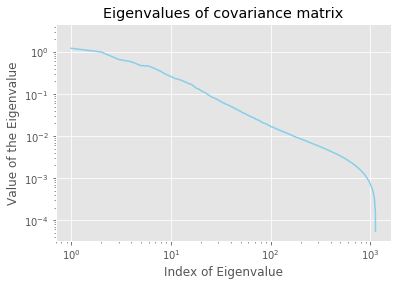

In [21]:
#use logscale, becasue seems to be power law
plt.loglog(eigval_list,color="skyblue")
plt.title("Eigenvalues of covariance matrix")
plt.ylabel("Value of the Eigenvalue")
plt.xlabel("Index of Eigenvalue")
plt.show()

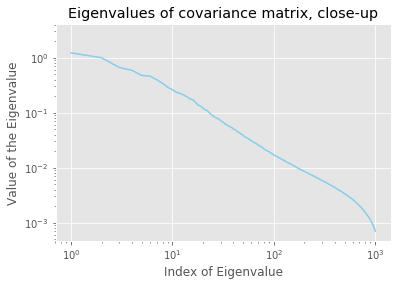

In [22]:
plt.loglog(eigval_list[:1007],color="skyblue")
plt.title("Eigenvalues of covariance matrix, close-up")
plt.ylabel("Value of the Eigenvalue")
plt.xlabel("Index of Eigenvalue")
plt.show()

Almost all eigenvalues are very small. Only approximately 20 eigenvalues are bigger than 0.1. That is the reason why we can capture a lot of information using only a few dimensions in the part below.

#### Implications

*  Explain the implications for dimensionality reduction.


PCA expressing the data in terms of the computed priciple components. The bigger the principle component the more variance it represents. So with a few biggest components one will be able to represent a big amount of variance in the data. Using only of fewe components reduces the dimensionality a lot while still representing most of the variance means that not much data is lost.


E.g. how many principal directions do you need to capture 2/3 of the variability in the data

In [23]:
#get P(x<=X)>2/3 , X is cumulus in this case
cumulus=np.cumsum(eigval_list)/np.sum(eigvalues)
important_principal_directions= [n for n,i in enumerate(cumulus) if i>(2./3.)]
important_principal_directions[0]

36

We need 36 principal directions to capture 2/3 of the variability in the data

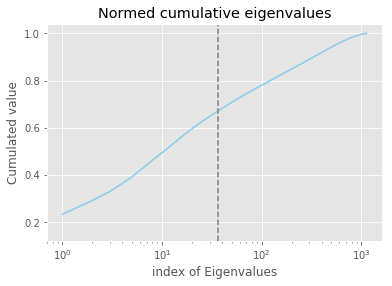

In [24]:
plt.semilogx(cumulus,color="skyblue")
plt.title("Normed cumulative eigenvalues")
plt.ylabel("Cumulated value")
plt.xlabel("index of Eigenvalues")
plt.axvline(important_principal_directions[0],linestyle="dashed",color="grey")
plt.show()

With the first 36 eigenvalues (and the corresponding principal directions) we can capture 2/3 of the data variability. So we can model the original dimension space that is bigger than 1000 with only 36 dimensions and still keep 2/3 of the information from the original data. This shows that we can use PCA very well for dimensionality reduction because it preserves  a lot of information while only using a few most important principal components.


---
## Exercise 3.2 - Concept Space

For the five first principal directions, find the 10 tags that have the highest and lowest
coordinates in that direction.



In [25]:
#get five biggest eigenvalues, the corresponding eigenvectors are the first five pricipal directions
eigval_five=eigval_list[:5]
print(eigval_five)
#eigenvectores are reversed
eigvec_five_rev=eigvectores[:,-5:].T
eigvec_five=eigvec_five_rev[::-1]

[2.7533774797813497, 1.2214710425886668, 0.9960515193084873, 0.662175500207405, 0.5857297851139419]


In [26]:
for i in range(5):  
    indices = np.argsort(eigvectores[:, -(i+1)])
    lowest_10 = indices[:10]
    top_10 = indices[-10:][::-1]
    print('\n\033[1mEigenvector ',i+1,'\033[1m\n')
    print('             \033[1m highest | lowest\033[0m')
    for top, low in zip(top_10, lowest_10):
        print("{: >20} {: >20}".format(tag2name[top+1], tag2name[low+1])) #Do I need to put plus one here, I think so?


Eigenvector  1 

              highest | lowest
               talky          predictable
   social commentary    so bad it's funny
           criterion             bad plot
        imdb top 250                silly
        great acting            silly fun
               drama             horrible
oscar (best directing)            franchise
               bleak                 lame
            dramatic           big budget
      cinematography               comedy

Eigenvector  2 

              highest | lowest
            intimate               action
       relationships      special effects
           criterion           big budget
         melancholic                chase
          loneliness           fast paced
         golden palm             suspense
          meditative          good action
           art house                 plot
          melancholy                pg-13
              sexual        action packed

Eigenvector  3 

              highest | lowest
           

*  What concepts would you use to describe these dimensions?

**Eigenvector 1:** highly acclaimed vs  low quality movie  --> ***overall movie quality and ratings*** (or "heaviness" of movie)

**Eigenvector 2:** emotionally deep vs superficial --> ***emotional depth in movie***

**Eigenvector 3:** postive,relaxing vs scary  --> ***feelings the movie transports***

**Eigenvector 4:** science fiction vs thriller  -->  ***distance to reality***

**Eigenvector 5:** thriller vs comedy --> ***seriousness of plot/movie***


* Create a Python dict which maps every tag (name) to its coordinates in the 5 first principal directions and save it to disk. This will be used later for the clustering exercise.

In [27]:
import pickle

eigenspace = np.dot(eigvec_five, M_zeromean)
projection = np.dot(M_zeromean, eigenspace.T)

tags_mapped = {}

for key, value in tag2name.items():
    tags_mapped[value] = projection[key-1,:]
    
#to pickle
with open('tag_embedding.pickle', 'wb') as handle:
    pickle.dump(projection, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tags_mapped.pickle', 'wb') as handle:
    pickle.dump(tags_mapped, handle, protocol=pickle.HIGHEST_PROTOCOL)

---
## Exercise 3.3 - Movie visualization



In [28]:
#get data
with open('selected-movies.pickle', 'rb') as handle:
    selected_movies = pickle.load(handle, encoding='utf-8') # encoding='latin1'

In [29]:
#get data from selected movies to make plotting easier
indx = []
names = []
ratings = []
for row in selected_movies:
    movie_id = row[0]
    movie_name= row[1]
    movie_rating = row[2]
    #matrix form 3.1
    movie_index = movieId_matrix.index(movie_id)
    indx.append(movie_index)
    names.append(movie_name)
    ratings.append(movie_rating)

* Project the movies of selected-movies.pickle on the first two principal directions.

In [30]:
# pick only selected movies from movie matrix
selected_M = M[:,indx]
print (selected_M.shape)

#get the ffirst two eigenvectors
pca_2d = eigvec_five.T[:,:2]
print(pca_2d.shape)

#project the movie matrix on the two eigenvectors
projected = pca_2d.T.dot(selected_M)
print(projected.shape)

(1128, 37)
(1128, 2)
(2, 37)




* Create an interactive plot that displays the 2D-projection of the movies using bokeh and its hover tool. Color the nodes by their Rotten Tomatoes score.


This score corresponds to the percentage of newspaper reviews that rate the movie favorably. See https: www.rottentomatoes.com


In [31]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib as mpl
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import HoverTool
output_notebook()

#define points
source = ColumnDataSource(
        data={
            "x": projected[0,:],
            "y":projected[1,:],
            "desc":names,
            "rating":ratings,
            #color depending on rating red, bad , green good
            "color":[
    "#%02x%02x%02x" % (255-int(r), int(g), 0) for r, g, b, _ in 255*mpl.cm.viridis(mpl.colors.Normalize()(ratings))
]
        }
    )

#hover tool, show rating
hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Name", "@desc"),
            ("Rating", "@rating"),
        ]
    )

p = figure(plot_width=400, plot_height=400, tools=[hover],
           title="Visualization of selected movie ratings, projected")
p.xaxis.axis_label = 'First Principal Component (overall movie quality and ratings)'
p.yaxis.axis_label = 'Second Principal Component (emotional depth in movie)'

p.circle(x='x',y= 'y', fill_alpha=0.2, color="color", size=10, source=source)

show(p)

Loading BokehJS ...

*  Based on your knowledge of these movies and information that you can get from the web, explain the coordinates of a few of the movies.

* How do the PCA directions correlate with the Rotten Tomatoes score?



Generally, one can see that the better rated movies are more to the right side of the graph while the bad ratings can be found on the left. So the first PCA direction seems to correlate with the rotten tomato scores. That makes sense as we labelled the first principle component as "overall movie quality and ratings" in the section above.

We labelled the second eigenvector as "emotional depth in movie". That fits quite well. If we take the movie **The Matrix**, it is rated quite well in rotten tomatos and correspondingly pretty far to the right for the first principal component. The movie is a mix if sci-fi and action and does not really focus on human realtionships. So it does not have much emotional depth, which makes it be very low on the second component. 

Similar insight applies to **Fight Club**. We can see though that fight club is much further to the right on the first priciple component. That is probably because the key words (drama, dramatic, social commentray) from the first eigenvector fit it better than The Matrix. Also, though The Matrix won some oscars and awards they where mostly for visual effects but Fight Club also has awards for the acting. For the principle component we can say that Fight Club focuses a bit on human relationships and love which puts it closer to the middle of the second principal component. It is interesting to notice that IMDb recommends The Matrix and Forest Gump when visiting the Fight Club IMDb page. All those movies are quite close together so IMDb seems to use similar principal components for recommendation.

If we take a look on **Just My Luck** this movie is basically the opposite to The Matrix. It is only about love and realtionships, so it is supposed to be about emotionally deep topics but it is more of a silly, bad rated movie. Thus low on the first but high on the second component.

Try projecting the movies on subsequent principal directions. Does it make sense based on your knowledge of these movies? (Not needed for the hand-in)